In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler,Normalizer
import numpy as np
import csv,os
%matplotlib inline

C:\Users\subhajit.choudhury\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv(r'C:\Users\subhajit.choudhury\Desktop\machine learning\kaggle\titanic\train.csv')
testdf = pd.read_csv(r'C:\Users\subhajit.choudhury\Desktop\machine learning\kaggle\titanic\test.csv')
predictionsfile = r'C:\Users\subhajit.choudhury\Desktop\machine learning\kaggle\titanic\submission_4.csv'

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#df[df['Survived']==1]

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
#df.isnull().sum()

In [7]:
#df.plot.scatter('PassengerId','Fare',c='Survived',figsize=(15,10),colormap='bwr')
#df.plot.scatter('PassengerId','TicketLen',c='Survived',figsize=(15,10),colormap='bwr')
# data = df.groupby(['TicketLen','Survived']).count()['Alone']
# data_pcts = data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
# data_pcts

In [8]:
df['Title'] = df.Name.apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
df['NameLen'] = df.Name.apply(lambda x: len(x))
df['FamilySize'] = df.Parch + df.SibSp + 1
df['Alone'] = df['FamilySize'].apply(lambda x:1 if x==1 else 0)
df['TicketLen'] = df.Ticket.apply(lambda x: 1 if len(x) in [5,8] else 0)
df['CabinGrp'] = df.Cabin.apply(lambda x: 0 if pd.isnull(x) else 1)

In [9]:
testdf['Title'] = testdf.Name.apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
le_title= LabelEncoder()
le_title.fit(pd.concat([df.Title,testdf.Title]))
# le_title.classes_
df['Title'] = le_title.transform(df['Title'])

In [10]:
df['AgeGrp'] = df['Age'].apply(lambda x: 'U60' if (pd.isnull(x) or x>=60)  else('0-15' if x<15 else ('15-60' if (x>=15 and x<60) else 'None')))
#                                else('0-15' if x<15 \
#                                     else ('15-30' if (x>=15 and x<30) \
#                                           else ('30-40' if (x>=30 and x<40) \
#                                                 else ('40-60' if (x>=40 and x<60) \
#                                                       else ('60+' if x>=60 else 'None') ) ) ) ) )
data = df.groupby(['AgeGrp','Survived']).count()['Alone']
data_pcts = data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
data_pcts
le_agegrp= LabelEncoder()
le_agegrp.fit(df.AgeGrp)
df['AgeGrp'] = le_agegrp.transform(df['AgeGrp'])

In [11]:
df['Age'] = df['Age'].apply(lambda x: 65 if pd.isnull(x) else x)

In [12]:
df['FareGrp'] = df['Fare'].apply(lambda x: '0-10' if x<10 else ('10-50' if x<50 else('50-100' if x<100 else '>=100' )))
#                                else('0-15' if x<15 \
#                                     else ('15-30' if (x>=15 and x<30) \
#                                           else ('30-40' if (x>=30 and x<40) \
#                                                 else ('40-60' if (x>=40 and x<60) \
#                                                       else ('60+' if x>=60 else 'None') ) ) ) ) )
data = df.groupby(['FareGrp','Survived']).count()['Alone']
data_pcts = data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
data
le_faregrp= LabelEncoder()
le_faregrp.fit(df.FareGrp)
df['FareGrp'] = le_faregrp.transform(df['FareGrp'])

In [13]:
df_passengerlist = df.PassengerId
df = df.dropna(subset=['Embarked'])
le_sex= LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])
#df['Cabin'] = le.fit_transform(df['Cabin'].astype(str))
le_embarked= LabelEncoder()
df['Embarked'] = le_embarked.fit_transform(df['Embarked'])
#df.Age.fillna(df.Age.mean(),inplace=True)
df = df.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

In [14]:
#df.head()

In [15]:
# dfage = df[df.Age.notna()].copy()
# dfagena = df[df.Age.isna()].copy()

In [16]:
# bins = list(np.arange(0,85,5))
# labels = list(range(1,len(bins)))
# dfage.AgeGrp = pd.cut(dfage.Age,bins=bins,labels=None)
# #df[['Age','AgeGrp']]
# data = dfage.groupby(['AgeGrp','Survived']).count()['Alone']
# data_pcts = data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
# data

In [17]:
#df.AgeGrp.value_counts()
# df.groupby(['AgeGrp','Survived']).count()['Alone']
# df.groupby(['AgeGrp','Survived']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [18]:
# plt.figure(figsize=(15,5))
# corr = dfage.corr()
# sns.heatmap(corr,annot=True)
# plt.show()

In [19]:
# dfage = dfage[['AgeGrp','Sex','SibSp','Parch','Title']]
# dfagena = dfagena[['Sex','SibSp','Parch','Title']]

In [20]:
# dfage.groupby(['AgeGrp']).count()['Sex']

In [21]:
# x = dfage.drop('AgeGrp',axis=1)
# y = dfage['AgeGrp']
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)

In [22]:
# scoredict = {}
# #options = np.linspace(0.1, 0.5, 5, endpoint=True)
# options = range(2,15)
# for opt in options:
# #     forest = RandomForestClassifier(random_state = 42,n_estimators=opt,criterion='gini',max_depth=6,max_features='auto',\
# #                                  min_samples_split=24, min_samples_leaf=2)
#     forest = RandomForestClassifier(random_state=42,n_estimators=4,criterion='gini',max_depth=4,max_features='auto',\
#                                    min_samples_split=opt, min_samples_leaf=2)
#     scores = cross_val_score(forest,x,y,cv=10,scoring='accuracy')
#     score = scores.mean()
#     scoredict[opt] = score
# plt.figure(figsize=(15,3))
# plt.plot(scoredict.keys(),scoredict.values())
# plt.show()

In [23]:
# forest_age =RandomForestClassifier(random_state=42,n_estimators=20,criterion='gini',max_depth=6,max_features='auto',\
#                                 min_samples_split=10, min_samples_leaf=2)
# forest_age.fit(x,y)
# # knn = KNeighborsClassifier()
# # knn.fit(x,y)

In [24]:
# forest_age.predict(dfagena)
# #knn.predict(dfagena)

In [25]:
# #df.AgeGrp.value_counts()
# df.loc[df.AgeGrp==16 ,'AgeGrp'] = forest_age.predict(df[df.AgeGrp==16][['Sex','SibSp','Parch','Title']])

In [26]:
# df.hist(figsize=(10,6))
# plt.show()

In [27]:
# class_cols = list(df.drop(['Survived','Age','Fare'],axis=1).columns)
# cont_cols = ['Age','Fare']

In [28]:
# for col in class_cols:
#     df.groupby(['Survived',col]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,2))

In [29]:
# fig, ax = plt.subplots()
# df.plot.scatter('Fare','Age',c='Survived',colormap='Spectral',figsize=(15,3),ax = ax)
# plt.show()

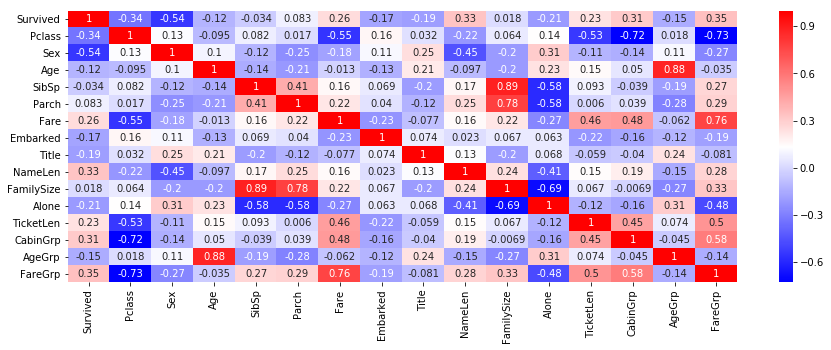

In [30]:
plt.figure(figsize=(15,5))
corr = df.corr()
# plt.figure(figsize=(20,10))
# plt.matshow(corr)
# plt.xticks(range(len(corr.columns)), corr.columns);
# plt.yticks(range(len(corr.columns)), corr.columns);
# plt.show()
sns.heatmap(corr,annot=True,cmap='bwr')
plt.show()

In [31]:
df = df.drop(['SibSp','Parch','FamilySize'],axis=1)
df = df.drop(['Age','Fare'],axis=1)
#df = df.drop(['CabinGrp'],axis=1)

In [32]:
x = df.drop('Survived',axis=1)
y = df['Survived']

In [33]:
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
# scaler = Normalizer()
x_scaled = scaler.fit_transform(x)

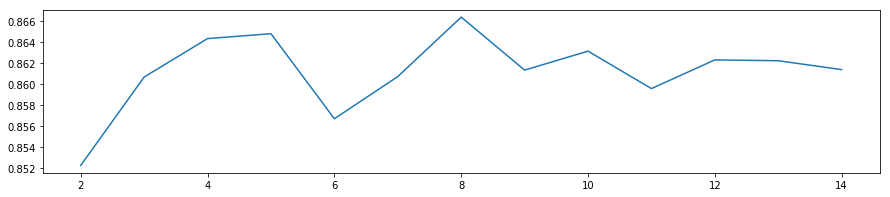

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y)
scoredict = {}
#options = np.linspace(0.1, 0.5, 5, endpoint=True)
options = range(2,15)
for opt in options:
#     forest = RandomForestClassifier(random_state = 42,n_estimators=opt,criterion='gini',max_depth=6,max_features='auto',\
#                                  min_samples_split=24, min_samples_leaf=2)
    forest = RandomForestClassifier(random_state=42,n_estimators=28,criterion='gini',max_depth=opt,\
                                   min_samples_split=10, min_samples_leaf = 2)
    scores = cross_val_score(forest,x,y,cv=10,scoring='roc_auc')
    score = scores.mean()
    scoredict[opt] = score
plt.figure(figsize=(15,3))
plt.plot(scoredict.keys(),scoredict.values())
plt.show()
#criterion='gini',max_features=None,max_depth=4,min_samples_split=4,min_samples_leaf=opt

In [35]:
# forest = RandomForestClassifier(random_state = 42)
# n_estimators = range(1,30)
# max_depth = range(1,10)
# min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True) 
# min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# criterion_options = ["gini","entropy"]
# max_features = ['auto', 'sqrt', 'log2']

In [36]:
# param_grid = dict(n_estimators=n_estimators, criterion = criterion_options, 
#                   #max_depth = max_depth, 
#                   #min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, 
#                   max_features = max_features)
# grid = GridSearchCV(forest,param_grid,cv=10,scoring="accuracy",verbose=2)
# #grid = RandomizedSearchCV(forest,param_grid,cv=10,scoring="accuracy")
# grid.fit(x,y)
# #print(grid.grid_scores_)
# print(grid.best_score_)
# print(grid.best_params_)

In [37]:
# forest=RandomForestClassifier(n_estimators=20,criterion='gini',max_depth=6,max_features='auto',\
#                               min_samples_split=24, min_samples_leaf=2)
forest =RandomForestClassifier(random_state=42,n_estimators=28,criterion='gini',max_depth=8,\
                               min_samples_split=10, min_samples_leaf=2) 
forest.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=28, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
testdf_bck = testdf
# testdf.head()

In [39]:
testdf.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

In [40]:
testdf['Title'] = testdf.Name.apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
testdf['NameLen'] = testdf.Name.apply(lambda x: len(x))
testdf['FamilySize'] = testdf.Parch + testdf.SibSp + 1
testdf['Alone'] = testdf['FamilySize'].apply(lambda x:1 if x==1 else 0)
testdf['TicketLen'] = testdf.Ticket.apply(lambda x: 1 if len(x) in [5,8] else 0)
testdf['CabinGrp'] = testdf.Cabin.apply(lambda x: 0 if pd.isnull(x) else 1)

In [41]:
testdf['Title'] = le_title.transform(testdf['Title'])

In [42]:
testdf['AgeGrp'] = testdf['Age'].apply(lambda x: 'U60' if (pd.isnull(x) or x>=60)  else('0-15' if x<15 else ('15-60' if (x>=15 and x<60) else 'None')))
testdf['AgeGrp'] = le_agegrp.transform(testdf['AgeGrp'])

In [43]:
testdf['Age'] = testdf['Age'].apply(lambda x: 65 if pd.isnull(x) else x)

In [44]:
testdf['FareGrp'] = testdf['Fare'].apply(lambda x: '0-10' if x<10 else ('10-50' if x<50 else('50-100' if x<100 else '>=100' )))
testdf['FareGrp'] = le_faregrp.transform(testdf['FareGrp'])

In [45]:
testdf_passengerlist = testdf.PassengerId
#testdf = testdf.dropna(subset=['Embarked'])
#testdf = testdf.dropna(subset=['Fare'])
testdf['Sex'] = le_sex.transform(testdf['Sex'])
#testdf['Cabin'] = le.fit_transform(testdf['Cabin'].astype(str))
testdf['Embarked'] = le_embarked.transform(testdf['Embarked'])
#testdf.Age.fillna(testdf.Age.mean(),inplace=True)
testdf.Fare.fillna(testdf.Fare.mean(),inplace=True)
testdf = testdf.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

In [46]:
testdf = testdf.drop(['SibSp','Parch','FamilySize'],axis=1)
testdf = testdf.drop(['Age','Fare'],axis=1)
#testdf = testdf.drop(['CabinGrp'],axis=1)
# testdf[:100]

In [47]:
testdf_scaled = scaler.fit_transform(testdf)
predictions = forest.predict(testdf)

In [48]:
with open(predictionsfile,'w') as writefile:
    writer = csv.writer(writefile)
    writer.writerow(['PassengerId','Survived'])
    for i in range(len(testdf_passengerlist)):
        row = [testdf_passengerlist[i],predictions[i]]
        writer.writerow(row)

In [49]:
testdf['Survived'] = predictions

In [50]:
df.groupby('Survived').count()

,Pclass,Sex,Embarked,Title,NameLen,Alone,TicketLen,AgeGrp,FareGrp
Survived,,,,,,,,,
0,549,549,549,549,549,549,549,549,549
1,340,340,340,340,340,340,340,340,340


In [51]:
testdf.groupby('Survived').count()

,Pclass,Sex,Embarked,Title,NameLen,Alone,TicketLen,AgeGrp,FareGrp
Survived,,,,,,,,,
0,279,279,279,279,279,279,279,279,279
1,139,139,139,139,139,139,139,139,139


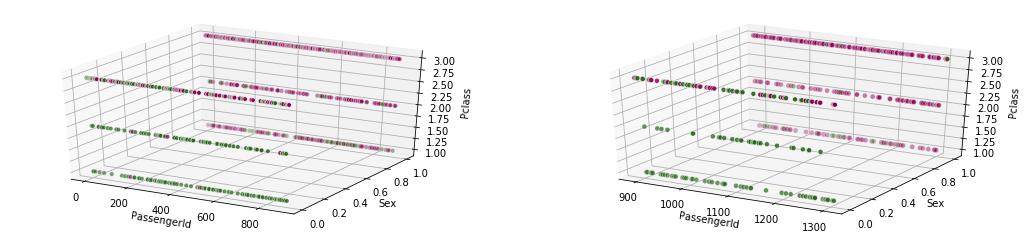

In [52]:
df['PassengerId'] = df_passengerlist
testdf['PassengerId'] = testdf_passengerlist
# fig, ax = plt.subplots()
# df.plot.scatter('Age','Sex',c='Survived',colormap='coolwarm',figsize=(20,2), ax = ax)
# plt.show()
fig = plt.figure(figsize=(18,4))
#fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(df.PassengerId, df.Sex, df.Pclass, c=df.Survived, cmap='PiYG', linewidth=0.5, s=20, edgecolors='w')
ax.set_xlabel('PassengerId')
ax.set_ylabel('Sex')
ax.set_zlabel('Pclass')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(testdf.PassengerId, testdf.Sex, testdf.Pclass, c=testdf.Survived, cmap='PiYG', linewidth=0.5, s=25, edgecolors='w')
ax.set_xlabel('PassengerId')
ax.set_ylabel('Sex')
ax.set_zlabel('Pclass')
plt.show()

In [53]:
# fig, ax = plt.subplots()
# testdf.plot.scatter('Age','Sex',c='Survived',colormap='coolwarm',figsize=(20,2), ax = ax)
# plt.show()

In [54]:
# testdf['Name'] = testdf_bck['Name']
# testdf[testdf['Survived']==1]
testdf_bck['Survived'] = testdf['Survived']
#testdf_bck.loc[testdf_bck.Survived==1]
testdf_bck

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,NameLen,FamilySize,Alone,TicketLen,CabinGrp,AgeGrp,FareGrp,Survived
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,1,12,16,1,1,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,2,13,32,2,0,0,0,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,1,12,25,1,1,0,0,2,0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,2,12,16,1,1,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,2,13,44,3,0,0,0,1,1,0
5,897,3,"Svensson, Mr. Johan Cervin",1,14.0,0,0,7538,9.2250,NaN,2,12,26,1,1,0,0,0,0,0
6,898,3,"Connolly, Miss. Kate",0,30.0,0,0,330972,7.6292,NaN,1,9,20,1,1,0,0,1,0,1
7,899,2,"Caldwell, Mr. Albert Francis",1,26.0,1,1,248738,29.0000,NaN,2,12,28,3,0,0,0,1,1,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,18.0,0,0,2657,7.2292,NaN,0,13,41,1,1,0,0,1,0,1
9,901,3,"Davies, Mr. John Samuel",1,21.0,2,0,A/4 48871,24.1500,NaN,2,12,23,3,0,0,0,1,1,0
